In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -qq transformers

In [ ]:
import os
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
os.chdir('gdrive/MyDrive/CS772')

FileNotFoundError: ignored

In [ ]:
!pwd

/content/gdrive/My Drive/CS772


In [ ]:
df = pd.read_csv("train.csv")
df.drop("Unnamed: 0",axis =1,inplace=True)
df.head()

,reviews,ratings
0,"This book was very informative, covering all a...",4
1,I am already a baseball fan and knew a bit abo...,5
2,I didn't like this product it smudged all unde...,1
3,I simply love the product. I appreciate print ...,5
4,It goes on very easily and makes my eyes look ...,5


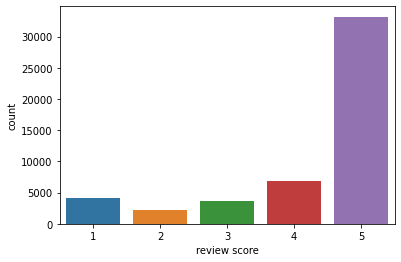

In [ ]:
sns.countplot(df.ratings)
plt.xlabel('review score');

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
token_lens = []
for txt in df.reviews:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


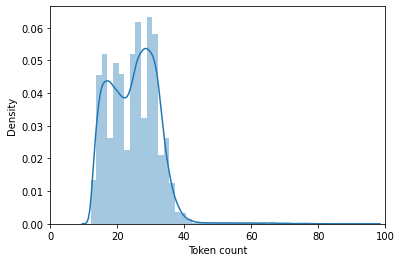

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 30

In [ ]:
class ReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_val = pd.read_csv("gold_test.csv")
df_val.drop("Unnamed: 0",axis =1,inplace=True)
df_val.head()

,reviews,ratings
0,Doesn't work at ALL. Don't waste your money or...,1
1,What crap. Would need a lot more power to do ...,1
2,Has no suction and didn't work. Not worth trying.,1
3,That is definitely a trash. Unable to clean an...,1
4,Didn't even worked on cleaning the ears at all...,1


In [ ]:
# df_train, df_test = train_test_split(
#   df,
#   test_size=0.1,
#   random_state=RANDOM_SEED
# )
# df_val, df_test = train_test_split(
#   df_test,
#   test_size=0,
#   random_state=RANDOM_SEED
# )
df_train = df

In [ ]:
df_train.shape, df_val.shape

((50000, 2), (10000, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ReviewDataset(
    reviews=df.reviews.to_numpy(),
    targets=df.ratings.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:

print(data['input_ids'].shape)
print(data['input_ids'])
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 30])
tensor([[  101,  1188,  1520,  1108,  1304, 12862,  5838,   117,  4576,  1155,
          5402,  1104,  1342,   119,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,   146,  1821,  1640,   170,  3866,  5442,  1105,  1450,   170,
          2113,  1164,  1103, 13898,  8903,   117,  1133,   146,  3560,   170,
          1974,  1167,  3455,  1142,  1520,   119,   102,     0,     0,     0],
        [  101,   146,  1238,   112,   189,  1176,  1142,  3317,  1122,   188,
         13601, 17363,  1155,  1223,  1139,  1257,  1194,  1193,  1103,  1285,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,   146,  2566,  1567,  1103,  3317,   119,   146,  8856,  5911,
          4877,  1171,  4423,  1139,  1546,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1135,  294

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(5)
model = model.to(device)


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
# input_ids = data['input_ids']
# attention_mask = data['attention_mask']
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq lengt

torch.Size([16, 30])
torch.Size([16, 30])


In [ ]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3737, 0.1020, 0.1437, 0.1655, 0.2152],
        [0.2507, 0.1470, 0.3078, 0.1636, 0.1309],
        [0.3472, 0.1287, 0.2091, 0.1451, 0.1698],
        [0.2630, 0.0993, 0.2177, 0.1455, 0.2745],
        [0.3150, 0.1328, 0.2112, 0.1102, 0.2308],
        [0.2385, 0.1490, 0.3035, 0.1091, 0.1999],
        [0.3430, 0.0624, 0.2315, 0.1332, 0.2299],
        [0.2715, 0.0884, 0.3787, 0.1064, 0.1550],
        [0.2597, 0.1516, 0.1831, 0.1339, 0.2716],
        [0.2413, 0.0835, 0.2885, 0.0783, 0.3083],
        [0.3221, 0.1399, 0.1854, 0.0779, 0.2746],
        [0.2064, 0.1803, 0.2887, 0.1603, 0.1642],
        [0.1241, 0.0860, 0.4071, 0.0712, 0.3116],
        [0.2510, 0.0613, 0.3754, 0.0878, 0.2245],
        [0.2030, 0.1156, 0.3995, 0.0841, 0.1979],
        [0.3753, 0.1171, 0.2071, 0.0898, 0.2108]], grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"] - 1 
    targets = targets.to(device)
    # input_ids = d["input_ids"]
    # attention_mask = d["attention_mask"]
    # targets = d["targets"] - 1 
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    # print(preds)
    # print(outputs)
    # print(targets)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"] - 1 
      targets = targets.to(device)
    #   input_ids = d["input_ids"]
    #   attention_mask = d["attention_mask"]
    #   targets = d["targets"] - 1 
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
    #   print(preds)
    #   print(outputs)
    #   print(targets)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


KeyboardInterrupt: ignored

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [ ]:
model.load_state_dict(torch.load('best_model_state.bin'), strict=False)


<All keys matched successfully>

In [ ]:
test_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(df_val)
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulti

0.7373000000000001

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"] - 1 
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions + 1, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.68      0.80      0.73      1271
           2       0.39      0.13      0.19       630
           3       0.41      0.45      0.43       911
           4       0.45      0.28      0.35      1404
           5       0.85      0.95      0.90      5784

    accuracy                           0.74     10000
   macro avg       0.56      0.52      0.52     10000
weighted avg       0.70      0.74      0.71     10000



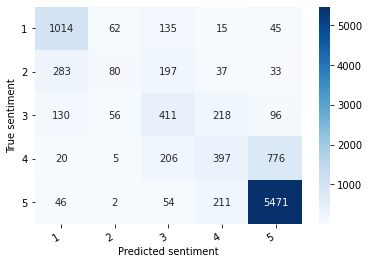

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[str(i) for i in range(1,6)], columns=[str(i) for i in range(1,6)])
show_confusion_matrix(df_cm)

In [ ]:
! pip install lime

     |████████████████████████████████| 276kB 7.7MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=3632f72ec035c97e47bfc4f9e809c845511a311b9eaeb6291e694d9e252ab141
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer
import torch
torch.cuda.empty_cache()

model1 = SentimentClassifier(5)
model1 = model1.to(device)
model1.load_state_dict(torch.load('best_model_state.bin'), strict=False)
tokenizer1 = BertTokenizer.from_pretrained('bert-base-cased')
class_names = ['1','2', '3','4','5']

def predictor(texts):
    ay = []
    for text in texts:
      encoded_review = tokenizer1.encode_plus(
      texts,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      )
      
      input_ids = encoded_review['input_ids'].to(device)
      attention_mask = encoded_review['attention_mask'].to(device)
      output = model1(input_ids, attention_mask)
      output = F.softmax(output)
      _, prediction = torch.max(output, dim=1)
      # print(prediction)
      ay.extend(output)
      
      # print(output)
      
    predictions = torch.stack(ay).cpu().detach().numpy()
    return predictions

def predict_prob(sent):
    if isinstance(sent,list):
        out = predictor(sent)
        return(out)
    elif isinstance(sent,str):
        out = predictor([sent])
        print('out',out)
        return(out)
    else:
        return("Some ERRORRRR")

explainer = LimeTextExplainer(class_names=class_names)

str_to_predict = "surprising increase in revenue in spite of decrease in market share"
exp = explainer.explain_instance(str_to_predict, predict_prob,num_features=30)
exp.show_in_notebook(text=str_to_predict)

RuntimeError: ignored